In [206]:
# Tensor_trains 
using TensorTrains, TensorCast, Tullio, LogarithmicNumbers, ProgressMeter, LinearAlgebra
using TensorTrains: compress, TruncBondThresh  

# MonteCarlo
using Random, Statistics, Distributions

# Graphics
using Plots, Colors

using Revise

include("tensor_builder.jl")
include("calculo_observables.jl")
include("monte_carlo_Glauber.jl")
include("parallel_monte_carlo_Glauber.jl")
include("monte_carlo_swap.jl")

compute_marginal_magnetization_parallel_swap

In [8]:
"""
    plot_two_sextuples(times, Sdots, Slines; site_labels=nothing, savepath=nothing)

Grafica dos series temporales de vectores por sitio:
- `times`: vector de tiempos (length T)
- `Sdots`: datos para graficar como puntos — forma N×T o T×N
- `Slines`: datos para graficar como líneas — forma N×T o T×N

Cada fila i corresponde al sitio i. Si la entrada viene en orientación time×sites,
la función la transpone automáticamente.

Opciones:
- `site_labels`: vector de etiquetas para leyenda (por defecto "Sitio 1", ...).
- `savepath`: si no es `nothing` guarda la figura en ese archivo (PNG, PDF, ...).
"""
function plot_two_Ntuples(times, Sdots, Slines; site_labels=nothing, savepath=nothing)
    # Normalizar formatos: queremos N × T
    if size(Sdots,1) == length(times) && size(Sdots,2) != length(times)
        Sdots = permutedims(Sdots)   # T×N -> N×T
    end
    if size(Slines,1) == length(times) && size(Slines,2) != length(times)
        Slines = permutedims(Slines)
    end

    @assert size(Sdots) == size(Slines) "Sdots y Slines deben tener la misma forma"
    N, T = size(Sdots)
    @assert length(times) == T "length(times) debe coincidir con número de columnas en Sdots/Slines"

    # Etiquetas por sitio
    if site_labels === nothing
        site_labels = ["Sitio $i" for i in 1:N]
    else
        @assert length(site_labels) == N "site_labels debe tener longitud N"
    end

    cols = distinguishable_colors(N)  # paleta con N colores distinguibles

    p = plot(title="Marginal expectation per spin over steps",
             xlabel="Tiempo", ylabel="Valor",
             legend=:outerright, grid=true, size=(900,500))

    # Dibujar: línea para Slines (con label) y puntos para Sdots (sin duplicar labels)
    for i in 1:N
        plot!(p, times, Slines[i, :],
              color=cols[i], linewidth=2, label=site_labels[i])
        scatter!(p, times, Sdots[i, :],
                 color=cols[i], marker=:circle, markersize=4, label=false)
    end

    if savepath !== nothing
        savefig(p, savepath)
    end

    return p
end

plot_two_Ntuples

## Pruebas

In [9]:
N = 50
t = 100
max_bound = 5

# TensotTrain de transición simpmle
A = build_transition_tensorchain(transition_rate, random_params(N))
# TensorTrain de probabilidad tiempo t simple
B_t = tensor_b_t(A, random_P0(N), t, max_bound)

# TensorTrain de transición paralela
A_plus = parallel_transition_tensor_train(transition_rate, parallel_random_params(N))

# TensorTrain de probabilidad tiempo t paralela con cadenas independientes
B_t_plus = tensor_b_t(A_plus, random_P0(N, 4), t, max_bound)

# TensorTrain de probabilidad tiempo t paralela con condiciones iniciales fijas
B_t_plus_fixed = tensor_b_t(A_plus, parallel_random_P0_fixed(N), t, max_bound)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


TensorTrain{Float64, 3, Array{Float64, 3}, LogFloat64}([[0.21475577006450614 0.28033872349277716 -0.23187152073179382 0.3026811541441355;;; 0.23187303705692644 0.3026799925463651 0.21475664489915117 -0.28033805331393885;;; 0.28033709199939105 -0.21475512120637893 -0.3026826652022149 -0.2318721216901716;;; 0.30268150360631985 -0.23187363801058875 0.2803364218173023 0.21475599604919732], [0.23212055912096988 0.275633626878218 … 0.037874611502039225 0.2816883178983484; 0.005192024504255261 0.03502551225507711 … -0.24435157509144742 0.035851426393594496; -0.001390097041422088 -0.0016515702678418047 … -0.00023322692251281498 -0.02987847040969573; 3.107518808412487e-5 0.000209826404931712 … -0.0014639899709874978 0.0037811938220330865;;; 0.23861389755587367 0.2833281568700618 … 0.03878446703696586 -0.27404155919495093; 0.005337408120089495 0.03600259981201846 … -0.25117425109534836 -0.03444020015116987; 0.0013525392102432285 0.001604965981119953 … 0.00021226304504661975 -0.03020210510529438;

In [10]:
println("Suma total de B_t: ", sum_one_check(B_t))
println("Suma total de B_t_plus: ", sum_one_check(B_t_plus))
println("Suma total de B_t_plus_fixed: ", sum_one_check(B_t_plus_fixed),"\n")
println("Distribución marginal en el sitio 10 de B_t: ", marginal_distribution(B_t, 10))
println("Distribución marginal en el sitio 10 de B_t_plus: ", marginal_distribution(B_t_plus, 10))
println("Distribución marginal en el sitio 10 de B_t_plus_fixed: ", marginal_distribution(B_t_plus_fixed, 10),"\n")
println("Valor esperado marginal en el sitio 10 de B_t: ", marginal_expected_value_simple(B_t, 10))
println("Valor esperado marginal en el sitio 10 de B_t_plus: ", marginal_expected_value_parallel(B_t_plus, 10))
println("Valor esperado marginal en el sitio 10 de B_t_plus_fixed: ", marginal_expected_value_parallel(B_t_plus_fixed, 10))

Suma total de B_t: 1.0000000000000036
Suma total de B_t_plus: 0.9999999999999885
Suma total de B_t_plus_fixed: 1.0

Distribución marginal en el sitio 10 de B_t: [0.29085755256219986, 0.7091424474378045]
Distribución marginal en el sitio 10 de B_t_plus: [0.13562676719586922, 0.17445588313881144, 0.30176260193515003, 0.3881547477301575]
Distribución marginal en el sitio 10 de B_t_plus_fixed: [0.13562676719587088, 0.1744558831388134, 0.30176260193515314, 0.38815474773016156]

Valor esperado marginal en el sitio 10 de B_t: 0.41828489487560466
Valor esperado marginal en el sitio 10 de B_t_plus: (0.12522126173794967, 0.37983469933062686)
Valor esperado marginal en el sitio 10 de B_t_plus_fixed: (0.125221261737951, 0.3798346993306304)


## Parallel Dynamic

In [155]:
N = 10                                 # Número de espines
T = 100                               # Número de iteraciones (tiempo)
params = parallel_random_params(N)      # beta_1, beta_2, j_vector, h_vector, p0
P0 = parallel_random_P0_fixed(N)        # Configuración inicial aleatoria fija para X e Y

# MonteCarlo
P0_Monte_Carlo = [P0[k][4] for k in 1:N]
params_mc = GlauberParamsParallel( params.beta_1, params.beta_2, params.j_vector, params.h_vector, params.p0)
result_mc = run_parallel_monte_carlo(N, params_mc, P0_Monte_Carlo, T, N_samples = 10000, seed = 42)

mag_mc_time = compute_marginal_magnetization_parallel(result_mc)   # magnetización de cada espín por instante de tiempo

# TensorTrains
max_bound = 5

A_plus = parallel_transition_tensor_train(transition_rate, params)
B_t_plus_fixed = tensor_b_t_over_time(A_plus, P0, T, max_bound)

mag_tt_time = [marginal_ev_parallel_system(B_t_plus_fixed[k]) for k in 1:T]

print("done")

In [ ]:
# params = (
#     N = 10,
#     beta_1 = 0.5,
#     beta_2 = 1.0,
#     j_vector = randn(N-1),
#     h_vector = randn(N),
#     p0 = 0.1
# )

In [156]:
print(params)

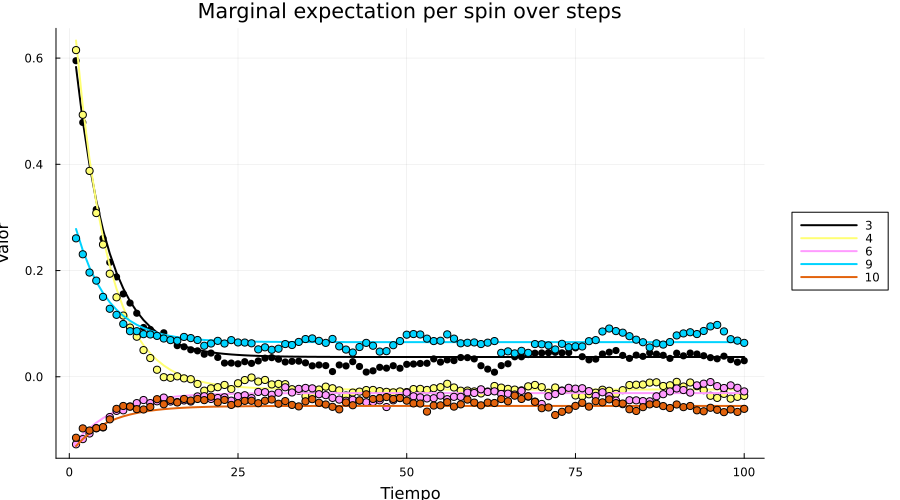

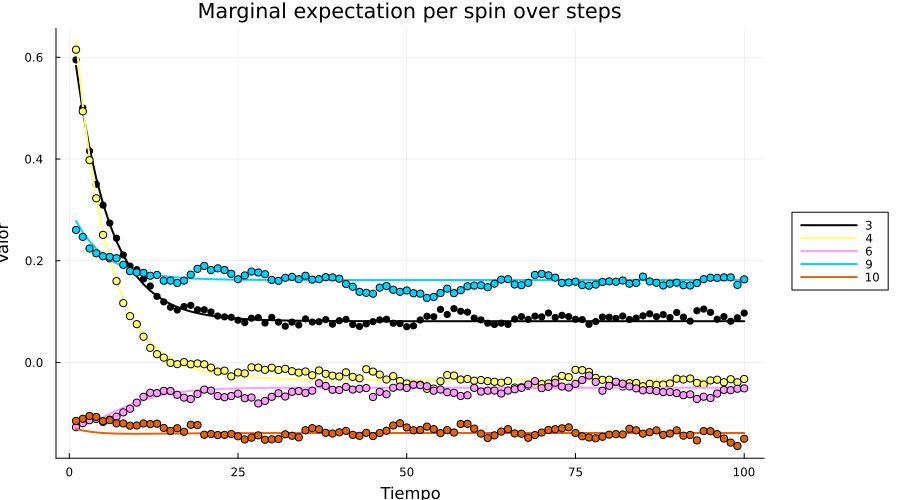

In [160]:
numbers_of_spins = 5
lista_of_spins = sort(randperm(N)[1:numbers_of_spins])
str_lista = string.(lista_of_spins)

for system in 1:2
    Sdots = mag_mc_time[system][lista_of_spins, 1:T] # N x T

    Slines = zeros(size(Sdots))                        # N x T
    for k in 1:T
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Slines[j, k] = mag_tt_time[k][spin_idx][system]
        end
    end

    times = 1:T            # o el vector de tiempos que uses (length == size(spins_tt,2))
    p = plot_two_Ntuples(times, Sdots, Slines;
                           site_labels = str_lista,
                           savepath="sextuples_compare.png")
    display(p)
end

In [18]:
system_of_correlations = []
for t in 1:10
    push!(system_of_correlations, correlation_between_chains(B_t_plus_fixed[t]))
end

print(correlation_between_chains(B_t_plus_fixed[1]), "\n", covariance_between_chains(B_t_plus_fixed[1]), "\n")

[1.0, 0.9999999999999997, 0.9999999999999999, 0.9999999999999996, 0.9999999999999996, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999998, 0.9999999999999997, 0.9999999999999999, 0.9999999999999998, 0.9999999999999999]
[0.7345817734695282, 0.8814091150333754, 0.9917760143477882, 0.6721694508262961, 0.8301463100630173, 0.6081033568721392, 0.8465810845886623, 0.668568322393907, 0.921930967759546, 0.9998912390297944, 0.9668952500124388, 0.7141560933542674, 0.7835551482483281, 0.8522309970964285, 0.989063623328007, 0.8663932326905572, 0.9515364574209324, 0.915602229389334, 0.9425084313024894, 0.908790447329235]


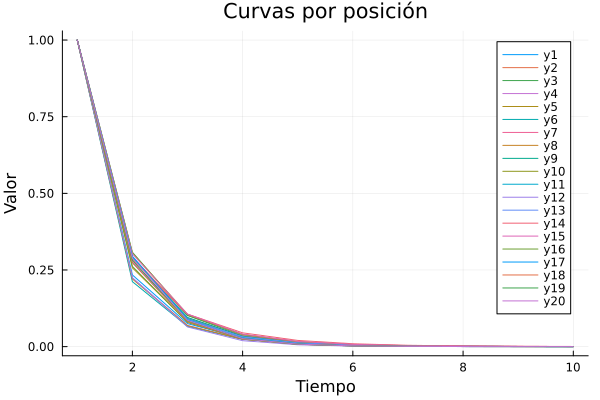

In [19]:
using Plots

# data: lista de T listas de N elementos
mat = hcat(system_of_correlations...)  # Convierte a matriz N x T
plot(mat' , legend=:topright, xlabel="Tiempo", ylabel="Valor", title="Curvas por posición")

### Some index references

    ( X  Y)

1-  (-1 -1)

2-  ( 1 -1)

3-  (-1  1)

4-  ( 1  1)

mag_tt_time[time][spin][X-Y]

mag_mc_time[X-Y][spin,time]

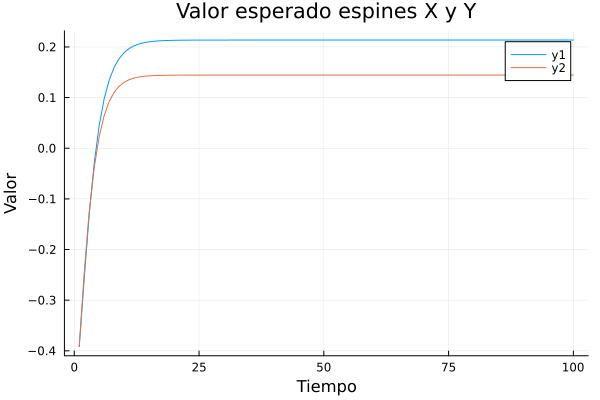

In [21]:
spin_X_ev_time = []
spin_Y_ev_time = []
spin_number = 7
for t in 1:100
    evs_X = mag_tt_time[t][spin_number][1]  # Valor esperado del espín X en el tiempo t
    evs_Y = mag_tt_time[t][spin_number][2]  # Valor esperado del espín Y en el tiempo t
    push!(spin_X_ev_time, evs_X)
    push!(spin_Y_ev_time, evs_Y)
end
mat_ev = hcat(spin_X_ev_time, spin_Y_ev_time)'  # Convierte a matriz 2 x T
plot(mat_ev', legend=:topright, xlabel="Tiempo", ylabel="Valor", title="Valor esperado espines X y Y")  

## Swap

In [141]:
N = 10                                 # Número de espines
# params = parallel_random_params(N)      # beta_1, beta_2, j_vector, h_vector, p0

P0 = parallel_random_P0_fixed(N)        # Configuración inicial aleatoria fija para X e Y


10-element Vector{Vector{Float64}}:
 [0.3660610025564186, 0.0, 0.0, 0.6339389974435814]
 [0.31361027068141606, 0.0, 0.0, 0.6863897293185839]
 [0.43155592912669033, 0.0, 0.0, 0.5684440708733097]
 [0.48134103225230296, 0.0, 0.0, 0.518658967747697]
 [0.5823803293514813, 0.0, 0.0, 0.41761967064851857]
 [0.961981128438708, 0.0, 0.0, 0.038018871561291884]
 [0.37231502933637145, 0.0, 0.0, 0.6276849706636285]
 [0.4092465240138364, 0.0, 0.0, 0.5907534759861637]
 [0.31890376098474227, 0.0, 0.0, 0.6810962390152577]
 [0.261126436046993, 0.0, 0.0, 0.738873563953007]

In [ ]:
T = 100                               # Número de iteraciones (tiempo)

params = (
    N = 10,
    beta_1 = 0.01,
    beta_2 = 100.0,
    j_vector = fill(1, N-1),
    h_vector = fill(0,N),
    p0 = 0.1
)
  # Número de iteraciones (tiempo)
#params = parallel_random_params(N)  

s = 0.5

# MonteCarlo
P0_Monte_Carlo = [P0[k][4] for k in 1:N]
params_mc = GlauberParamsParallelSwap( params.beta_1, params.beta_2, params.j_vector, params.h_vector, params.p0, s)
result_mc_swap = run_swap_parallel_monte_carlo(N, params_mc, P0_Monte_Carlo, T, N_samples = 10000, seed = 42)

mag_mc_time_swap = compute_marginal_magnetization_parallel(result_mc_swap)   # magnetización de cada espín por instante de tiempo

# TensorTrains
bond = 5

A_plus = parallel_transition_tensor_train(transition_rate, params)
B_t_swap_fixed = tensor_b_t_swap(A_plus, P0, T, bond, s, true)
# B_t_parallel_fixed = tensor_b_t_over_time(A_plus, P0, T, bond)

mag_tt_time_swap = [marginal_ev_parallel_system(B_t_swap_fixed[k]) for k in 1:T]

print("done")



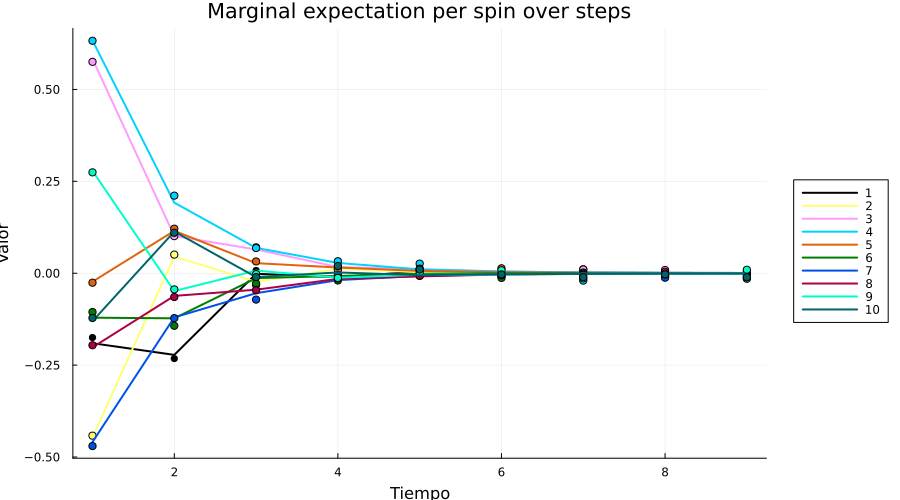

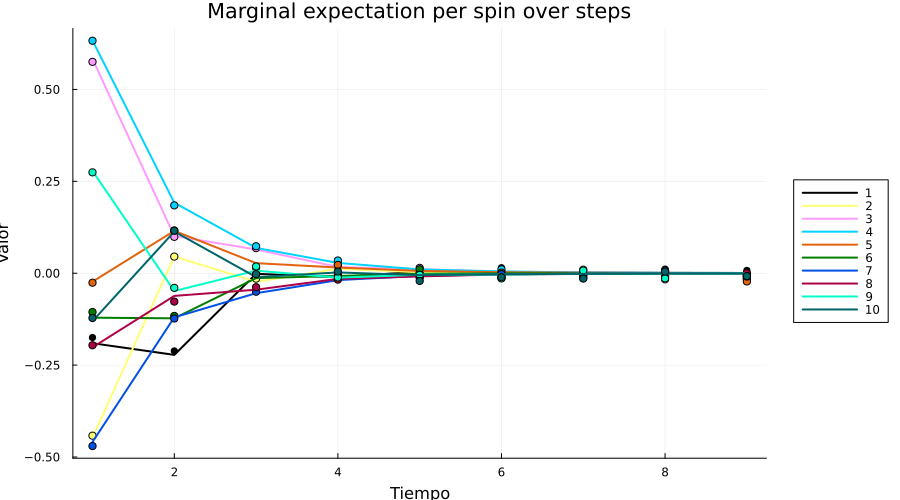

In [227]:
mag_tt_time_swap = [marginal_ev_parallel_system(B_t_swap_fixed[k]) for k in 1:T]

numbers_of_spins = 10
lista_of_spins = sort(randperm(N)[1:numbers_of_spins])
str_lista = string.(lista_of_spins)

T=9
for system in 1:2
    Sdots = mag_mc_time_swap[system][lista_of_spins, 1:T] # N x T

    Slines = zeros(size(Sdots))                        # N x T
    for k in 1:T
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Slines[j, k] = mag_tt_time_swap[k][spin_idx][system]
        end
    end

    times = 1:T            # o el vector de tiempos que uses (length == size(spins_tt,2))
    p = plot_two_Ntuples(times, Sdots, Slines;
                           site_labels = str_lista,
                           savepath="sextuples_compare.png")
    display(p)
end

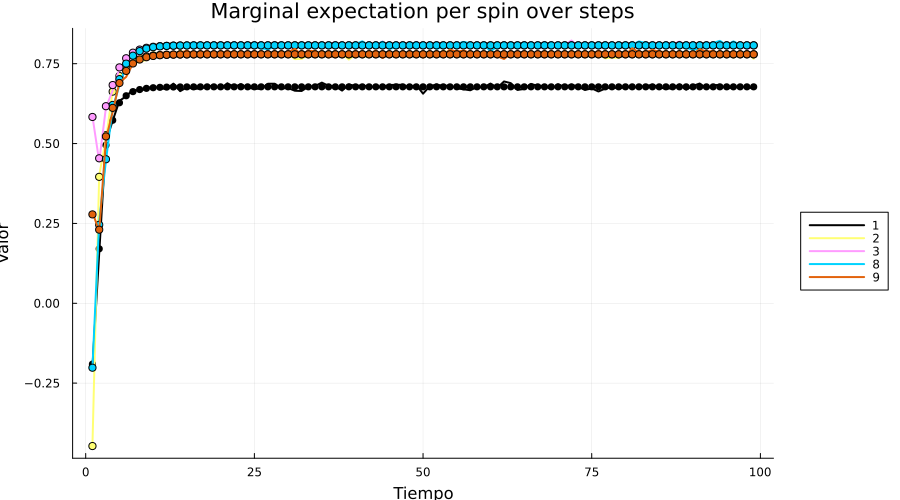

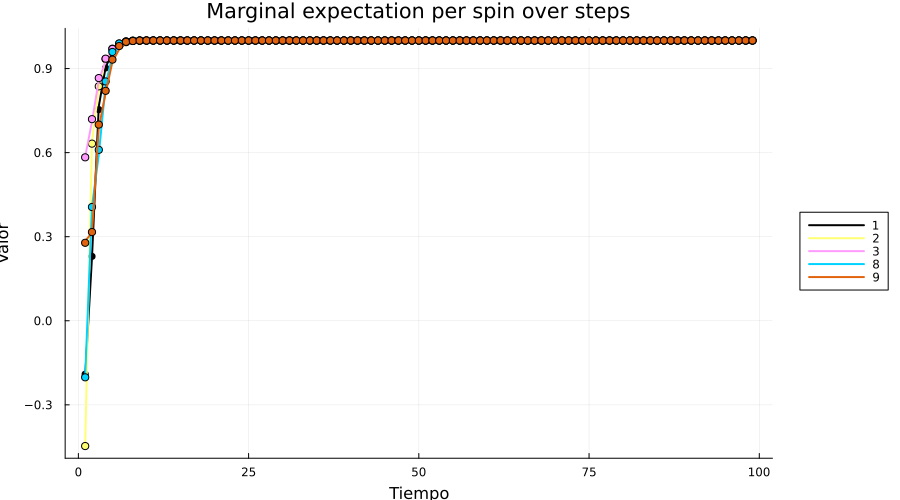

In [201]:
mag_tt_time_swap = [marginal_ev_parallel_system(B_t_swap_fixed[k]) for k in 1:T]
mag_tt_time_parallel = [marginal_ev_parallel_system(B_t_parallel_fixed[k]) for k in 1:T]

numbers_of_spins = 5
lista_of_spins = sort(randperm(N)[1:numbers_of_spins])
str_lista = string.(lista_of_spins)


for system in 1:2
    Sdots_ = mag_mc_time_swap[system][lista_of_spins, 1:T] # N x T

    Slines = zeros(size(Sdots_))                        # N x T
    for k in 1:T
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Slines[j, k] = mag_tt_time_swap[k][spin_idx][system]
        end
    end

    Sdots = zeros(size(Sdots_))                        # N x T
    for k in 1:T
        for j in 1:length(lista_of_spins)
            spin_idx = lista_of_spins[j]
            Sdots[j, k] = mag_tt_time_parallel[k][spin_idx][system]
        end
    end

    times = 1:T            # o el vector de tiempos que uses (length == size(spins_tt,2))
    p = plot_two_Ntuples(times, Sdots, Sdots_;
                           site_labels = str_lista,
                           savepath="sextuples_compare.png")
    display(p)
end

In [228]:
system_of_correlations = []
for t in 1:100
    push!(system_of_correlations, correlation_between_chains(B_t_swap_fixed[t]))
end

print(correlation_between_chains(B_t_swap_fixed[1]), "\n", covariance_between_chains(B_t_swap_fixed[1]), "\n")

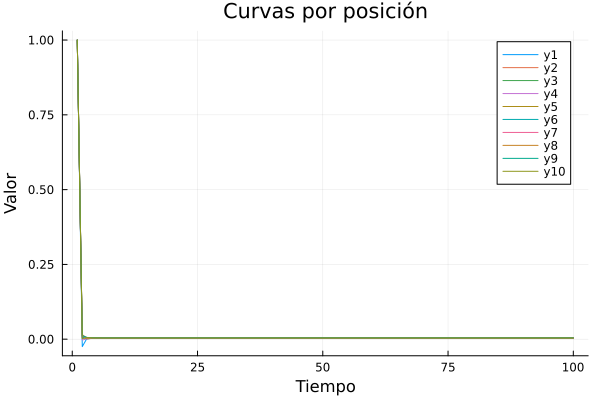

In [229]:
using Plots

# data: lista de T listas de N elementos
mat = hcat(system_of_correlations...)  # Convierte a matriz N x T
plot(mat' , legend=:topright, xlabel="Tiempo", ylabel="Valor", title="Curvas por posición")